PositionalEncoding 位置编码类
1. 初始化 传入参数d_model, max_len
   1. 父类初始化
   2. 参数初始化 self.d_model
   3. 初始化位置编码（max_len, d_model）和位置张量(max_len, 1)
   4. 计算位置编码分母 div (d_model/2, 1) $10000^{2i/d_model}$
   5. 计算位置编码pe，按奇偶分别计算
   6. pe増维(1, max_len, d_model)
   7. 给pe设置持久缓存
2. 前向 传入输入 x
   1. 放大x防止被位置编码淹没
   2. x + pe 注意pe要根据x的序列长度截断第二维

In [16]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        """
        为序列加入位置编码
        Args:
            d_model: 序列矩阵的embedding的维度
            max_len: 位置编码矩阵的最大序列长度, 这个长度可以比实际序列长度长, 相加时只要截取实际序列的长度即可
        """
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        
        pe = torch.zeros(max_len, d_model)  # 创建一个(max_len, d_model)的全零矩阵, 用于保存位置编码值
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # 创建一个(max_len, 1)的矩阵, 表示位置索引
        
        # 创建一个(d_model/2,)的矩阵, 用于储存每个维度的频率因子(每两列的频率因子是相同的, 因此一共有d_model/2个频率因子)
        # torch.arange(0, d_model, 2).float()相当于生成位置编码公式中的索引i
        # 使用log和exp分开计算能够确保在数值范围内进行线性缩放, 从而避免浮点数溢出或精度丢失
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # 计算位置编码
        # 对于维度的偶数列
        pe[:, 0::2] = torch.sin(position * div_term)  # 由广播机制：(max_len, 1)*(d_model/2,)->(max_len, d_model/2)
        # 对于维度的奇数列
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # 增加一个batch维度, 使其能够与输入张量相加
        pe = pe.unsqueeze(0)  # (max_len, d_model)->(1, max_len, d_model)
        # 将位置编码矩阵注册为模型的缓冲区, 这样它将不会被认为是模型的参数
        # 缓冲区会随着模型一起保存和加载
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        # 原文3.4节中提到, 为了使得单词嵌入表示相对大一些, 乘sqrt(d_model), 以确保嵌入向量的值不会被位置编码淹没。
        x = x * math.sqrt(self.d_model)
        
        # 将位置编码添加到输入张量上
        # 位置编码依据max_len生成, 而输入序列长度的seq_len应小于等于max_len
        # 通常会将输入序列补全或截断到统一长度, 让这个长度等于max_len即可
        x = x + self.pe[:, :x.size(1), :]
        return x


In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x *= math.sqrt(self.d_model)
        x += self.pe[:, :x.size(1), :]
        return x
        

torch.Size([32, 50, 512])


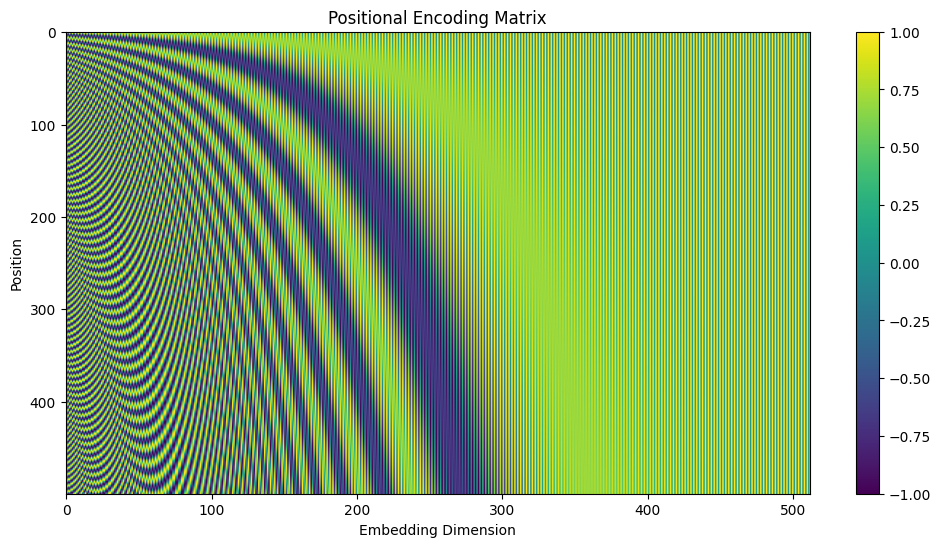

In [17]:
d_model = 512
pe = PositionalEncoding(d_model=d_model)

x = torch.randn(32, 50, d_model)

x = pe(x)

print(x.shape)

pe_matrix = pe.pe[0]

plt.figure(figsize=(12, 6))
plt.imshow(pe_matrix.detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Positional Encoding Matrix')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.show()

MultiHeadAttention 多头注意力类
1. 初始化 传入参数 d_model, num_heads, dropout
   1. 父类初始化
   2. 检查d_model 能否完整分为num_heads个头
   3. 计算q, k, v的维度 d_model // num_heads, d_v可以与前两者不一样，默认取一样
   4. 初始化参数 d_model, num_heads, d_k
   5. 定义网络层w_q, w_k, w_v, w_o, dropout, 四个线性层维度默认是(d_model, d_model)
2. 前向传播 传入输入 q, k, v, mask=None
   1. 获取batch_size x.size(0)
   2. 计算q, k, v
      1. 经过对应的线性层(batch_size, seq_len, d_model)
      2. 调整形状为(batch_size, seq_len, num_heads, d_k)
      3. 继续调整方便不同头分开计算(batch_size, num_heads, seq_len, d_k)
   3. 计算q, k的注意力分数
      1. 计算内积，注意k转置和内积的缩放
      2. 如果有mask，scores = scores.masked_fill(mask == 0, -1e9)
      3. 对最后一维计算softmax
      4. dropout，得到Attention(batch_size, num_heads, seq_len, seq_len)
   4. 计算输出
      1. 注意力分数与v进行内积 output(batch_size, num_heads, seq_len, d_k)
      2. 调整输出形状(batch_size, seq_len, num_heads, d_k)
      3. 设置张量连续存储 contiguous()
      4. 合并维度 (batch_size, seq_len, d_model)
      5. 经过线性层w_o
   5. 返回输出和注意力
   

In [ ]:
# 多头自注意力
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"  # 确保num_heads能整除d_model
        
        self.d_model = d_model
        self.d_k = d_model // num_heads  # 这里简单起见，我们只考虑 d_v = d_k = d_q = d_model / num_heads，因此只定义d_k
        self.h = num_heads

        # 这里定义的 linear 参数是 (d_model, d_model)
        self.q_linear = nn.Linear(d_model, d_model)  # W_Q
        self.k_linear = nn.Linear(d_model, d_model)  # W_K
        self.v_linear = nn.Linear(d_model, d_model)  # W_V
        self.o_linear = nn.Linear(d_model, d_model)  # W_O
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, q, k, v, mask=None):
        """
        input:
            q, k, v: (batch_size, seq_len, d_model)
                对于自注意力, 如果输入序列为 x, 那么 q=x, k=x, v=x
                对于交叉注意力, 如果序列 x_1 对序列 x_2 做 query, 则 q=x_1, k=x_2, v=x_2
            mask: (batch_size, 1, 1, seq_len)或(batch_size, 1, seq_len, seq_len)
                mask有多种形式, 可以使用0、1来mask, 也可以使用True、False来mask, 根据具体代码执行mask
        output:
            seq: (batch_size, seq_len, d_model)
            attention: (batch_size, h, len_q, len_k) 每个头均有一个注意力权重矩阵
                对于自注意力, len_q = len_k = len_v = seq_len
                对于交叉注意力, len_q = tgt_seq_len , len_k = len_v = src_seq_len
        """
        batch_size = q.size(0)
        
        # 将原始序列变换为QKV矩阵
        # 以 q 的变换为例。序列 q=x 经过 q_linear 变换后，形状仍然为(batch_size, seq_len, d_model)
        # 使用.view方法用于改变张量形状。这里变换成了(batch_size, seq_len, num_heads, d_k)，即把 d_model 拆成了 num_heads*d_k
        # 使用.transpose方法，将形状进一步变为(batch_size, num_heads, seq_len, d_k)
        q = self.q_linear(q).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)  # (batch_size, seq_len, d_model)->(batch_size, num_heads, seq_len, d_k)
        k = self.k_linear(k).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        
        # 每个头并行计算相似度得分，相似度矩阵形状为(batch_size, num_heads, len_q, len_k)
        # 即每个头都形成了(len_q, len_k)的 scores，scores 的第一行，意思是第一个位置的 q 对所有位置的 k 的得分，因此后续的 softmax 是按 scores 的行来做的
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k) # 默认乘最后两个维度的矩阵
        
        if mask is not None:
            # 这里我们假设mask中为0的地方是需要遮蔽的地方
            scores = scores.masked_fill(mask == 0, -1e9)  # 通过把掩码的位置设置为一个较大的负数，让掩码位置的softmax趋近于零
        
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)  # 得到所有batch的每个头的相似度矩阵
        
        # 相似度矩阵与v相乘得到输出
        output = torch.matmul(attention, v)  # (batch_size, num_heads, seq_len, d_k)
        
        # 首先将output变为(batch_size, seq_len, num_heads, d_k)
        # .contiguous用于确保张量在内存中是连续的
        # 将张量形状变为(batch_size, seq_len, d_model)，相当于把所有头的结果拼接了起来，即 d_k*num_heads 拼成了 d_model
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.o_linear(output)  # 使用w_o进行线性变换
        
        # 最终传出输出和每个头的attention，attention根据需要可用于后续的可视化
        return output, attention


In [38]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_k = d_model // num_heads
        self.d_model = d_model
        self.num_heads = num_heads
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.w_o = nn.Linear(d_model, d_model)
    def forward(self, q, k, v, mask=None, kv_cache=None):
        batch_size = q.size(0)
        q = self.w_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.w_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.w_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        if kv_cache is not None:
            k, v = kv_cache
            k = torch.cat([k, k], dim=-2)
            v = torch.cat([v, v], dim=-2)

        scores = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.d_k)
        if mask is not None:
            if scores.shape[-1] != mask.shape[-1]:
                pass
            scores = scores.masked_fill(mask==0, 1e-9)
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)

        output = torch.matmul(attention, v)
        output = output.transpose(-1, -2).contiguous().view(batch_size, -1, self.d_model)
        output = self.w_o(output)

        return output, attention, (k, v)

In [42]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.d_k = d_model // num_heads
        self.h = num_heads
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.o_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None, kv_cache=None):
        batch_size = q.size(0)
        q = self.q_linear(q).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        if kv_cache is not None:
            k_cache, v_cache = kv_cache
            k = self.k_linear(k).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
            v = self.v_linear(v).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
            k = torch.cat([k_cache, k], dim=-2)
            v = torch.cat([v_cache, v], dim=-2)
        else:
            k = self.k_linear(k).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
            v = self.v_linear(v).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)
        output = torch.matmul(attention, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.o_linear(output)
        return output, attention, (k, v)

torch.Size([32, 10, 512])
torch.Size([32, 8, 10, 10])
torch.Size([32, 8, 10, 64])


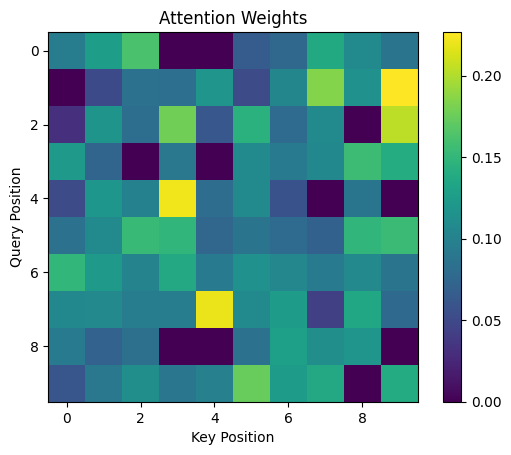

In [19]:
mha = MultiHeadAttention(d_model=512, num_heads=8)

x = torch.randn(32, 10, d_model)

output, attention, kv_cache = mha(x, x, x)

print(output.shape)
print(attention.shape)
print(kv_cache[0].shape)

# 可视化第0个batch的第0个头的attention
head_attention = attention[0, 0].detach().numpy()  # 提取第 0 个 batch 的第 0 个头

# 绘制热力图
plt.imshow(head_attention, cmap='viridis')
plt.colorbar()
plt.title('Attention Weights')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.show()

FeedForward 前馈神经网络 通常在注意力层之后
1. 初始化 传入参数 d_model, d_ff, dropout
   1. 父类初始化
   2. 定义升维线性层(d_model, d_ff)
   3. 定义dropout
   4. 定义降维线性层(d_model, d_ff)
2. 前向传播 传入参数 x
   1. 经过第一次线性层并计算relu激活
   2. 经过dropout
   3. 经过第二层线性层
   4. 输出结果

In [20]:
# 前馈神经网络
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        # d_ff 默认设置为 2048，更多的中间层节点数可以增加网络的容量，使其能够学习更复杂的函数映射。
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        """
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.w_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.w_1(x)))
        x = self.w_2(x)
        return x

LayerNorm 层归一化类 对每个样本的最后一位
1. 初始化 传入 d_model, eps
   1. 父类初始化
   2. 初始化缩放(1)和平移参数(0)(d_model,),要定义为可训练的参数
   3. 初始化epsilon
2. 前向传播 传入输入 x
   1. 针对输入的最后一维(d_model)计算均值和方差
   2. 归一化后进行缩放和偏移
   3. 返回结果

In [21]:
# 层归一化, 也可以使用PyTorch内置的层归一化nn.LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        # LayerNorm是对d_model而言的
        mean = x.mean(-1, keepdim=True)  # (batch_size, seq_len, 1)
        std = x.std(-1, keepdim=True)  # (batch_size, seq_len, 1)
        return self.a * (x - mean) / (std + self.eps) + self.b

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.a = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a*((x - mean)/(std + self.eps)) + self.b

EncoderLayer 编码器层类
1. 初始化 传入 d_model, num_heads, d_ff, dropout
   1. 父类初始化
   2. 定义两个层归一化层，分别用子多头注意力和前向的残差连接之后
   3. 定义多头注意力层
   4. 定义前向层
   5. 定义两个dropout分别用于多头注意力和前向之后
2. 前向 传入 x, src_mask=None
   1. 计算注意力后的输出
   2. 对输出进行dropout，然后连接残差，最后进行LayerNorm
   3. 继续经过前向网络，经过dropout，进行残差连接，最后LayerNorm
   4. 输出结果

In [22]:
# 编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        """
        每个EncoderLayer包括两个子层: 多头注意力层和前馈神经网络层。每个子层都使用了残差连接和层归一化。
        """
        super().__init__()
        self.norm_1 = LayerNorm(d_model)
        self.norm_2 = LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ff = FeedForward(d_model, d_ff=d_ff, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        """
        原文中使用: LayerNorm(x + SubLayer(x))
        也有部分实现使用: x + SubLayer(LayerNorm(x))
        这里我们使用原文的实现
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        output, _ = self.attn(x, x, x, mask=src_mask)
        x = self.norm_1(x + self.dropout_1(output))  # 多头自注意力子层
        x = self.norm_2(x + self.dropout_2(self.ff(x)))  # 前馈神经网络子层
        return x

In [30]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm_1 = LayerNorm(d_model)
        self.norm_2 = LayerNorm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
    def forward(self, x, src_mask=None):
        attn, _, kv = self.attn(x, x, x, mask = src_mask)
        x = self.norm_1(x + self.dropout_1(attn))
        x = self.norm_2(x + self.dropout_2(self.ffn(x)))
        return x

Encoder 编码器类 叠加多个编码器层
1. 初始化 传入 num_layers, d_model, num_heads, d_ff, dropout
   1. 父类初始化
   2. 定义多个编码器层
   3. 定义层归一化层加在整个编码器后
2. 前向 传入 x, src_mask
   1. 依次经过每个编码器层
   2. 最后经过层归一化

In [23]:
# 编码器
class Encoder(nn.Module):
    """
    编码器由多个编码器层堆叠而成。
    """
    def __init__(self, num_layers, d_model, num_heads, d_ff=2048, dropout=0.1):
        """
        在原始论文的图 1 和描述中, 作者提到每个子层(Multi-Head Attention 和 Feed-Forward Network)之后会进行 Layer Normalization。
        但是，论文并没有明确提到在整个编码器或解码器之后进行额外的 Layer Normalization。
        许多后续的实现，通常会在编码器和解码器的堆叠之后再进行一次 Layer Normalization。
        """
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, src_mask=None):
        """
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        for layer in self.layers:
            x = layer(x, src_mask)
        return self.norm(x)


In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = LayerNorm(d_model)
    def forward(self, x, src_mask=None):
        for layer in self.layers:
            x = layer(x, src_mask)
        return self.norm(x)

DecoderLayer 解码器层类
1. 初始化 传入 d_model, num_heads, d_ff. dropout
   1. 父类初始化
   2. 定义三个层归一化层，分别加在自注意力、交叉注意力和前馈层的残差连接后
   3. 定义自注意力层
   4. 定义交叉注意力层
   5. 定义前馈层
   6. 定义三个dropout层分别加载三个层的后面 ？一个
2. 前向 传入 x, enc_output, memory_mask, tgt_mask
   1. 对输入x计算自注意力attn，注意tgt_mask
   2. dropout，残差连接，层归一化
   3. 计算x和编码器输出的交叉注意力，注意传参，x是q, enc_mask
   4. dropout，残差连接，层归一化
   5. 经过前向，dropout，残差连接，层归一化
   6. 输出

In [ ]:
# 解码器层
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        """
        每个DecoderLayer包括三个子层: 自注意力层、编码器-解码器注意力层和前馈神经网络层。每个子层都使用了残差连接和层归一化。
        """
        super().__init__()
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        self.norm_3 = nn.LayerNorm(d_model)
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ff = FeedForward(d_model, d_ff=d_ff, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

    def forward(self, x, enc_output, memory_mask=None, tgt_mask=None):
        """
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        output_1, _ = self.self_attn(x, x, x, mask=tgt_mask)
        x = self.norm_1(x + self.dropout_1(output_1))  # 第一个子层：多头自注意力层
        
        output_2, _ = self.enc_dec_attn(x, enc_output, enc_output, mask=memory_mask)  # k, v来自编码器输出
        x = self.norm_2(x + self.dropout_2(output_2))  # 第二个子层：编码器-解码器注意力层
        
        x = self.norm_3(x + self.dropout_3(self.ff(x)))  # 第三个子层：前馈神经网络层
        return x

In [34]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.norm_1 = LayerNorm(d_model)
        self.norm_2 = LayerNorm(d_model)
        self.norm_3 = LayerNorm(d_model)
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, memory_mask=None, tgt_mask=None, kv_cache_self=None, kv_cache_enc_dec=None):

        output_1, _, kv_cache_self = self.self_attn(x, x, x, mask=tgt_mask, kv_cache=kv_cache_self)
        x = self.norm_1(x + self.dropout(output_1))  
        
        output_2, _, kv_cache_enc_dec = self.enc_dec_attn(x, enc_output, enc_output, mask=memory_mask, kv_cache=kv_cache_enc_dec)  # k, v来自编码器输出
        x = self.norm_2(x + self.dropout(output_2))  
        x = self.norm_3(x + self.dropout(self.ff(x)))  
        return x, kv_cache_self, kv_cache_enc_dec

Decoder 解码器类
1. 初始化 传入 num_layers, d_model, num_heads, d_ff, dropout
   1. 父类初始化
   2. 定义num_layers个解码器层
   3. 定义一个层归一化层用于叠加后的解码器层
2. 前向 传入 x, enc_output, memory_mask, tgt_mask
   1. 逐层传播
   2. 层归一化

In [ ]:
# 解码器
class Decoder(nn.Module):
    """
    解码器由多个解码器层堆叠而成。
    """
    def __init__(self, num_layers, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, enc_output, memory_mask=None, tgt_mask=None):
        """
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        for layer in self.layers:
            x = layer(x, enc_output, memory_mask, tgt_mask)
        return self.norm(x)

In [32]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = LayerNorm(d_model)
    def forward(self, x, enc_output, memory_mask=None, tgt_mask=None, kv_cache=None):
        if kv_cache is None:
            kv_cache = [None] * len(self.layers) * 2
        new_kv_cache = []
        for i, layer in enumerate(self.layers):
            x, kv_cache_self, kv_cache_enc_dec = layer(x, enc_output, memory_mask, tgt_mask, kv_cache[2 * i], kv_cache[2 * i + 1])
            new_kv_cache.extend([kv_cache_self, kv_cache_enc_dec])
        return self.norm(x), new_kv_cache

Transformer 完整的类
1. 初始化 传入 src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_len
   1. 父类初始化
   2. 定义源嵌入层，将序列的词表维度转换成d_model
   3. 定义目标嵌入层，将序列的词表维度转换成d_model
   4. 定义位置编码层，用于给输入添加位置编码
   5. 定义Encoder
   6. 定义Decoder
   7. 定义输出前向层
   8. 定义dropout
2. 前向 传入 src, tgt, src_mask, tgt_mask, memory_mask
   1. 对于源序列和目标序列分别进行，嵌入，增加位置编码，dropout
   2. 上述源序列的结果经过Encoder
   3. Encoder的输出和上述目标序列的结果经过Decoder
   4. 上述输出经过前向层

In [ ]:
# 完整Transformer模型
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_layers=6, num_heads=8, d_ff=2048, dropout=0.1, max_len=500):
        super().__init__()
        # src_vocab_size和tgt_vocab_size分别是源序列和目标序列的词典大小
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)  # 定义嵌入层，用于将序列转换为维度为d_model的嵌入向量
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)  # 位置编码层

        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, dropout)

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        """
        src和tgt为token_id
        src: (batch_size, src_seq_len)
        tgt: (batch_size, tgt_seq_len)
        在 Transformer 模型中, 输入序列通常已经经过填充(padding)处理。
        填充是为了使所有输入序列的长度一致，从而可以将它们放入一个批次中进行处理。
        """
        src = self.dropout(self.positional_encoding(self.src_embedding(src)))  # 位置编码后使用了dropout，原文在Regularization中有提到
        tgt = self.dropout(self.positional_encoding(self.tgt_embedding(tgt)))

        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, memory_mask, tgt_mask)
        
        # 在训练过程中，logits 通常会通过 CrossEntropyLoss 来计算损失，而 CrossEntropyLoss 会在内部应用 softmax
        # 因此这里可以不用softmax，在推理阶段，可以在output后手动加入softmax
        output = self.fc_out(dec_output)
        return output

In [26]:
from torch import ne


class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_layers=6,  num_heads=8, d_ff=2048, dropout=0.1, max_len=500):
        super().__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None, kv_cache=None):
        src = self.dropout(self.positional_encoding(self.src_embedding(src)))
        tgt = self.dropout(self.positional_encoding(self.tgt_embedding(tgt)))

        enc_output = self.encoder(src, src_mask)
        dec_output, new_kv_cache = self.decoder(tgt, enc_output, memory_mask, tgt_mask, kv_cache)

        output = self.fc_out(dec_output)
        return output, new_kv_cache

In [13]:
# 填充掩码
def make_padding_mask(seq, pad_id, return_int=True, true_to_mask=False):
    """
    构造padding mask, 参数设置根据不同的Transformer实现来确定
    Args:
        seq: 需要构造mask的序列(batch, seq_len), 该序列使还未进行Embedding, 里面放的是token_id
        pad_id: 用于填充的特殊字符<PAD>所对应的token_id, 根据不同代码设置
        return_int: 是否返回int形式的mask, 默认为True
        true_to_mask: 默认为False, 对于bool mask: True代表在True的位置遮蔽, False代表在False的位置遮蔽。对于int mask: True代表在1的位置遮蔽, False代表在0的位置遮蔽
    
    Returns:
        mask: (batch, seq_len), 不同的Transformer实现需输入的形状也不同, 根据需要进行后续更改
    """
    mask = (seq == pad_id)  # (batch, seq_len), 在<PAD>的位置上生成True, 真实序列的位置为False

    if true_to_mask is False:
        mask = ~mask
    
    if return_int:
        mask = mask.int()
    
    return mask

# 因果掩码
def make_sequence_mask(seq, return_int=True, true_to_mask=False):
    """
    构造sequence mask, 参数设置根据不同的Transformer实现来确定
    Args:
        seq: 需要构造mask的序列(batch, seq_len), 该序列使还未进行Embedding, 里面放的是token_id
        return_int: 是否返回int形式的mask, 默认为True
        true_to_mask: 默认为False, 对于bool mask: True代表在True的位置遮蔽, False代表在False的位置遮蔽。对于int mask: True代表在1的位置遮蔽, False代表在0的位置遮蔽
    
    Returns:
        mask: (seq_len, seq_len), 不同的Transformer实现需输入的形状也不同, 根据需要进行后续更改
    """
    _, seq_len = seq.shape
    mask = torch.tril(torch.ones(seq_len, seq_len))  # (seq_len, seq_len), 下三角为1, 上三角为0
    mask = 1 - mask
    mask = mask.bool()

    if true_to_mask is False:
        mask = ~mask
    
    if return_int:
        mask = mask.int()
    
    return mask

In [14]:
# 进一步分别构造src_mask、memory_mask、tgt_mask
def make_src_mask(src, pad_id, return_int=True, true_to_mask=False):
    """构造src_mask

    Args:
        src: 源序列(batch_size, src_len)
        pad_id: 补全符号的token_id
        return_int: 是否返回int形式的mask, 默认为True
        true_to_mask: 默认为False, 对于bool mask: True代表在True的位置遮蔽, False代表在False的位置遮蔽。对于int mask: True代表在1的位置遮蔽, False代表在0的位置遮蔽

    Returns:
        src_mask: (batch_size, 1, 1, src_len)
    """
    padding_mask = make_padding_mask(src, pad_id, return_int=return_int, true_to_mask=true_to_mask)
    padding_mask = padding_mask.unsqueeze(1)
    padding_mask = padding_mask.unsqueeze(2)
    return padding_mask

def make_memory_mask(src, pad_id, return_int=True, true_to_mask=False):
    """构造memory_mask

    Args:
        src: 源序列(batch_size, src_len)
        pad_id: 补全符号的token_id
        return_int: 是否返回int形式的mask, 默认为True
        true_to_mask: 默认为False, 对于bool mask: True代表在True的位置遮蔽, False代表在False的位置遮蔽。对于int mask: True代表在1的位置遮蔽, False代表在0的位置遮蔽

    Returns:
        memory_mask: (batch_size, 1, 1, src_len)
    """
    padding_mask = make_padding_mask(src, pad_id, return_int=return_int, true_to_mask=true_to_mask)
    padding_mask = padding_mask.unsqueeze(1)
    padding_mask = padding_mask.unsqueeze(2)
    return padding_mask

def make_tgt_mask(tgt, pad_id, return_int=True, true_to_mask=False):
    """构造tgt_mask

    Args:
        tgt: 目标序列(batch_size, tgt_len)
        pad_id: 补全符号的token_id
        return_int: 是否返回int形式的mask, 默认为True
        true_to_mask: 默认为False, 对于bool mask: True代表在True的位置遮蔽, False代表在False的位置遮蔽。对于int mask: True代表在1的位置遮蔽, False代表在0的位置遮蔽

    Returns:
        tgt_mask: (batch_size, 1, tgt_len, tgt_len)
    """
    padding_mask = make_padding_mask(tgt, pad_id, return_int=return_int, true_to_mask=true_to_mask)  # (batch_size, tgt_len)
    padding_mask = padding_mask.unsqueeze(1)
    padding_mask = padding_mask.unsqueeze(2)  # (batch_size, 1, 1, tgt_len)
    padding_mask = padding_mask.repeat(1, 1, tgt.size(1), 1)  # (batch_size, 1, tgt_len, tgt_len)

    sequence_mask = make_sequence_mask(tgt, return_int=True, true_to_mask=False)  # (tgt_len, tgt_len)
    sequence_mask = sequence_mask.unsqueeze(0)
    sequence_mask = sequence_mask.unsqueeze(1)  # (1, 1, tgt_len, tgt_len)
    sequence_mask = sequence_mask.repeat(tgt.size(0), 1, 1, 1)  # (batch_size, 1, tgt_len, tgt_len)

    # 合并两个mask
    if true_to_mask is False:  # 根据不同类型的mask, 使用"与"或"或"的方式进行合并
        mask = padding_mask & sequence_mask
    else:
        mask = padding_mask | sequence_mask
    return mask


In [43]:
# 初始化模型
src_vocab_size = 1000
tgt_vocab_size = 1000
model = Transformer(src_vocab_size, tgt_vocab_size)

# 准备输入数据
batch_size = 1
src_seq_len = 10
tgt_seq_len = 1
src = torch.randint(0, src_vocab_size, (batch_size, src_seq_len))
tgt = torch.randint(0, tgt_vocab_size, (batch_size, tgt_seq_len))

# 构造掩码
pad_id = 0
src_mask = make_src_mask(src, pad_id)
tgt_mask = make_tgt_mask(tgt, pad_id)
memory_mask = make_memory_mask(src, pad_id)

# 初始KV cache为None
kv_cache = None

# 推理过程
for _ in range(5):
    output, kv_cache = model(src, tgt, src_mask, tgt_mask, memory_mask, kv_cache)
    next_token = torch.argmax(output[:, -1, :], dim=-1, keepdim=True)
    tgt = torch.cat([tgt, next_token], dim=-1)
    tgt_mask = make_tgt_mask(tgt, pad_id)

print("Generated sequence:", tgt)

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 3